In [1]:
'''
尝试各种时频分析方法

'''

'\n尝试各种时频分析方法\n\n'

In [2]:

import numpy as np
import os.path as op
from pandas import read_csv
import mne
from mne.io import read_raw_fif
from mne.datasets import visual_92_categories
from neurora.nps_cal import nps
from neurora.rdm_cal import eegRDM
from neurora.rdm_corr import rdm_correlation_spearman
from neurora.corr_cal_by_rdm import rdms_corr
from neurora.rsa_plot import plot_rdm, plot_corrs_by_time, plot_nps_hotmap, plot_corrs_hotmap

1.296198742988373


In [3]:
"""
数据应该是从epochs里读，每个epoch的标签不一样才对
简化：
先读一个被试的数据看看
每个epoch对应一个condition（关键的是数量不对等问题-不同条件epoch数量不等，要不要随机抽取？假设每个抽取12个）

"""

num_sub = 0

T1_sub_ids = [
    'prex018','prex019'  ]

T2M_sub_ids = [
    'prex018M','prex019M' ]

T2S_sub_ids = [
    'prex018S','prex019S' ]

T1_sub_ids = [
    'prex019'  ]

T2M_sub_ids = [
    'prex019M' ]

T2S_sub_ids = [
    'prex019S' ]
data_path = 'E:\Python LYW\RSA\spaced_learning\pre10\\analysis\data\\6epoch_clean\\'

list_epochs_T1S = list()
list_epochs_T2S = list()
list_epochs_T2M = list()

for sub_id in T1_sub_ids:
    fname = data_path + sub_id + '-epo.fif'
    epochs = mne.read_epochs(fname)

    list_epochs_T1S.append(epochs)

for sub_id in T2S_sub_ids:
    fname = data_path + sub_id + '-epo.fif'
    epochs = mne.read_epochs(fname)
    list_epochs_T2S.append(epochs)

for sub_id in T2M_sub_ids:
    fname = data_path + sub_id + '-epo.fif'
    epochs = mne.read_epochs(fname)
    list_epochs_T2M.append(epochs)

Reading E:\Python LYW\RSA\spaced_learning\pre10\analysis\data\6epoch_clean\prex019-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
38 matching events found
No baseline correction applied
0 projection items activated
Reading E:\Python LYW\RSA\spaced_learning\pre10\analysis\data\6epoch_clean\prex019S-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Reading E:\Python LYW\RSA\spaced_learning\pre10\analysis\data\6epoch_clean\prex019M-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated


In [4]:
epochs_concatenate = mne.concatenate_epochs([list_epochs_T1S[0],list_epochs_T2M[0],list_epochs_T2S[0]])
print(epochs_concatenate)
epochs_concatenate.equalize_event_counts(method='mintime')
print(epochs_concatenate)
epochs = epochs_concatenate['101']
print(epochs)

Not setting metadata
131 matching events found
Applying baseline correction (mode: mean)
<Epochs |  131 events (all good), -0.2 - 0.8 sec, baseline -0.2 – 0 sec, ~32.1 MB, data loaded,
 '101': 38
 '102': 45
 '103': 48>
Dropped 17 epochs: 76, 77, 78, 79, 80, 81, 82, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130
<Epochs |  114 events (all good), -0.2 - 0.8 sec, baseline -0.2 – 0 sec, ~28.0 MB, data loaded,
 '101': 38
 '102': 38
 '103': 38>
<Epochs |  38 events (all good), -0.2 - 0.8 sec, baseline -0.2 – 0 sec, ~9.4 MB, data loaded,
 '101': 38>


In [5]:
epochs_Fp1 = epochs.pick_channels(['Fpz'])

    Using multitaper spectrum estimation with 7 DPSS windows


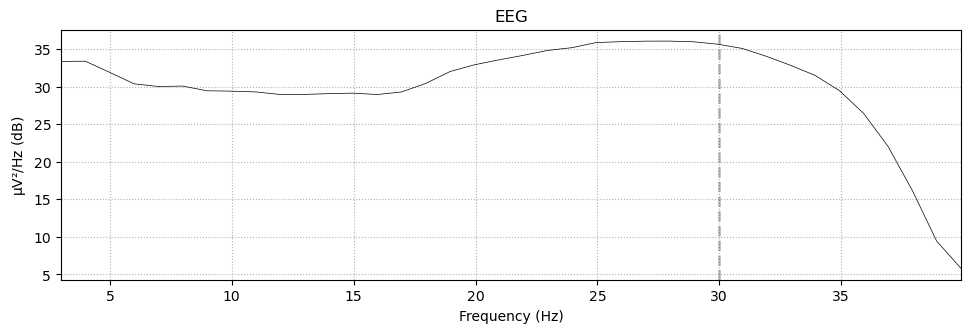

In [6]:
%matplotlib qt
epochs.plot_psd(fmin=2., fmax=40., average=True, spatial_colors=False)

Using matplotlib as 2D backend.
Opening epochs-browser...


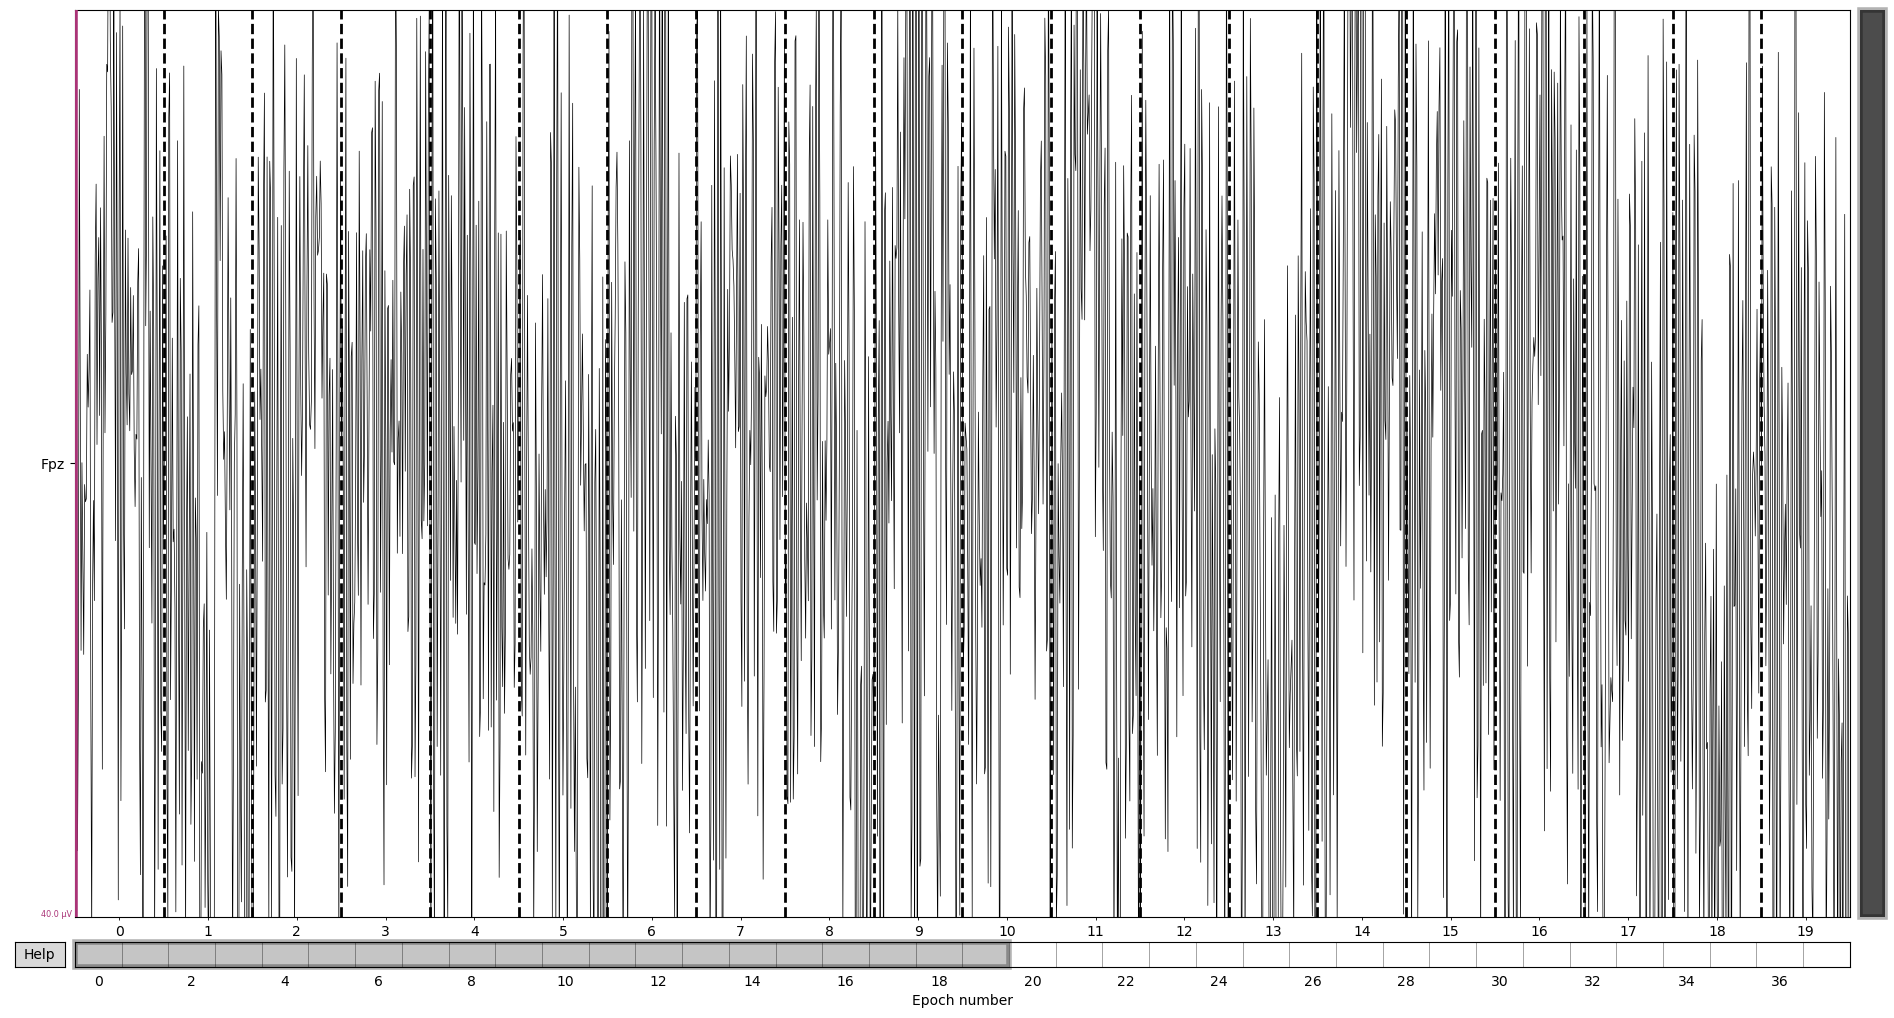

In [7]:
epochs_Fp1.plot()

<decorator-gen-203>:4: FutureWarning: NOTE: psd_multitaper() is a deprecated function. Function psd_multitaper() is deprecated; for Raw/Epochs/Evoked instances use spectrum = instance.compute_psd(method="multitaper") instead, followed by spectrum.get_data(return_freqs=True)..


TypeError: Got unexpected keyword argument reject_by_annotation for PSD method "multitaper".

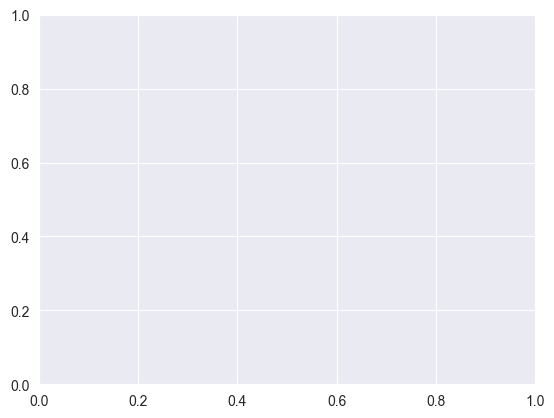

In [5]:
import matplotlib.pyplot as plt
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

f, ax = plt.subplots()
psds, freqs = psd_multitaper(epochs, fmin=2, fmax=40)
psds = 10 * np.log10(psds)  # convert to dB
psds_mean = psds.mean(0).mean(0)
psds_std = psds.mean(0).std(0)

ax.plot(freqs, psds_mean, color='k')
ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                color='k', alpha=.5)
ax.set(title='Multitaper PSD (XX chennel)', xlabel='Frequency (Hz)',
       ylabel='Power Spectral Density (dB)')
plt.show()

In [9]:
'''
时频分析
Time-frequency analysis: power and inter-trial coherence
'''
freqs = np.logspace(*np.log10([6, 35]), num=8)
print(freqs)

[ 6.          7.71912254  9.93080879 12.77618833 16.43682721 21.1463139
 27.2051647  35.        ]


In [10]:
from mne.time_frequency import tfr_multitaper
n_cycles = freqs / 2.  # different number of cycle per frequency
power, itc= tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, average=True, decim=3, n_jobs=1)

Applying baseline correction (mode: logratio)


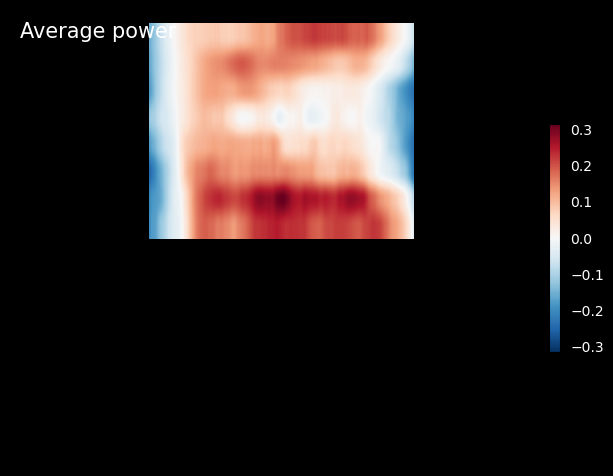

In [11]:
#基线扰动 - 应该给长一点？
from matplotlib.colors import TwoSlopeNorm
vmin, vmax = -1, 1.5
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
power.plot_topo(baseline=(-0.2, 0), mode='logratio', title='Average power')

In [12]:
# 某个频段，某个时间段，地形图
power.plot_topomap(tmin=0.1, tmax=0.3, fmin=4, fmax=8,
                   baseline=(-0.2, 0), mode='logratio',
                   title='Alpha', show=False)

Applying baseline correction (mode: logratio)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
itc.plot_topo(title='Inter-Trial coherence', vmin=0., vmax=1., cmap='Reds')


In [ ]:
'''
mmn 相减。
'''